# Get Started in 10 Minutes

```{article-info}
:author: Altay Sansal
:date: "{sub-ref}`today`"
:read-time: "{sub-ref}`wordcount-minutes` min read"
:class-container: sd-p-0 sd-outline-muted sd-rounded-3 sd-font-weight-light
```

In this page we will be showing basic capabilities of MDIO.

For demonstration purposes, we will download the Teapot Dome open-source dataset. The dataset details and licensing can be found at the [SEG Wiki](https://wiki.seg.org/wiki/Teapot_dome_3D_survey).

We are using the 3D seismic stack dataset named `filt_mig.sgy`.

The full link for the dataset (hosted on AWS): http://s3.amazonaws.com/teapot/filt_mig.sgy

```{warning}
For plotting, the notebook requires [Matplotlib](https://matplotlib.org/) as a dependency. Please install it before executing using
`pip install matplotlib` or `conda install matplotlib`.
```

## Defining the SEG-Y Dataset

Since MDIO 0.8 we can directly ingest remote SEG-Y files! The file is 386 MB in size. To make the header scan performant we can also
set up an environment variable for MDIO. See here for when to use this:
[Buffered Reads in Ingestion](https://mdio-python.readthedocs.io/en/stable/usage.html#buffered-reads-in-ingestion).

The dataset is irregularly shaped, however it is padded to a rectangle with zero (dead traces). We will see that later at the live mask plotting.

In [1]:
import os
os.environ["MDIO__IMPORT__CLOUD_NATIVE"] = "true"

url = "http://s3.amazonaws.com/teapot/filt_mig.sgy"

## Ingesting to MDIO

To do this, we can use the convenient SEG-Y to MDIO converter.

The `inline` and `crossline` values are located at bytes `181` and `185`. Note that this doesn't match any SEG-Y standards.

MDIO uses [TGSAI/segy][segy-github] to parse the SEG-Y; the field names conform to its canonical keys defined in [SEGY Binary Header Keys][segy-binary-keys] and [SEGY Trace Header Keys][segy-trace-keys]. MDIO interprets the trace headers as SEG-Y Rev1 for historical reasons and will be more flexible in the next generation.

`181` and `185` for Teapot should ideally map to `cdp_x` and `cdp_y` in the header arrays. However, because the file does not match the standard, they are mapped to the `inline` and `crossline` header keys on ingested headers.

In summary, we will use the byte locations as defined for ingestion. However, because `inline` / `crossline` and flipped with `cdp_x` / `cdp_y`, we must interchange the keys later.

[segy-github]: https://github.com/TGSAI/segy
[segy-binary-keys]: https://github.com/TGSAI/segy/blob/main/src/segy/standards/fields/binary.py
[segy-trace-keys]: https://github.com/TGSAI/segy/blob/main/src/segy/standards/fields/trace.py

In [3]:
from mdio import segy_to_mdio

segy_to_mdio(
    segy_path=url,
    mdio_path_or_buffer="filt_mig.mdio",
    index_bytes=(181, 185),
    index_names=("inline", "crossline"),
)

Ingesting SEG-Y in 18 chunks: 100%|██████████| 18/18 [00:06<00:00,  2.60block/s]


It only took a few seconds to ingest, since this is a very small file.

However, MDIO scales up to TB (that's ~1,000 GB) sized volumes!

## Opening the Ingested MDIO File

Let's open the MDIO file with the `MDIOReader`.

We will also turn on `return_metadata` function to get the live trace mask and trace headers.

In [4]:
from mdio import MDIOReader

mdio = MDIOReader("filt_mig.mdio", return_metadata=True)

## Querying Metadata

Now let's look at the Textual Header by the convenient `text_header` attribute.

You will notice the text header is parsed as a list of strings that are 80 characters long.

In [5]:
mdio.text_header

['C 1 CLIENT: ROCKY MOUNTAIN OILFIELD TESTING CENTER                              ',
 'C 2 PROJECT: NAVAL PETROLEUM RESERVE #3 (TEAPOT DOME); NATRONA COUNTY, WYOMING  ',
 'C 3 LINE: 3D                                                                    ',
 'C 4                                                                             ',
 'C 5 THIS IS THE FILTERED POST STACK MIGRATION                                   ',
 'C 6                                                                             ',
 'C 7 INLINE 1, XLINE 1:   X COORDINATE: 788937  Y COORDINATE: 938845             ',
 'C 8 INLINE 1, XLINE 188: X COORDINATE: 809501  Y COORDINATE: 939333             ',
 'C 9 INLINE 188, XLINE 1: X COORDINATE: 788039  Y COORDINATE: 976674             ',
 'C10 INLINE NUMBER:    MIN: 1  MAX: 345  TOTAL: 345                              ',
 'C11 CROSSLINE NUMBER: MIN: 1  MAX: 188  TOTAL: 188                              ',
 "C12 TOTAL NUMBER OF CDPS: 64860   BIN DIMENSION: 110' X 110'   

MDIO parses the binary header into a Python dictionary.

We can easily query it by the `binary_header` attribute and see critical information about the original file.

In [6]:
mdio.binary_header

{'job_id': 9999,
 'line_num': 9999,
 'reel_num': 1,
 'data_traces_per_ensemble': 188,
 'aux_traces_per_ensemble': 0,
 'sample_interval': 2000,
 'orig_sample_interval': 0,
 'samples_per_trace': 1501,
 'orig_samples_per_trace': 1501,
 'data_sample_format': 1,
 'ensemble_fold': 57,
 'trace_sorting_code': 4,
 'vertical_sum_code': 1,
 'sweep_freq_start': 0,
 'sweep_freq_end': 0,
 'sweep_length': 0,
 'sweep_type_code': 0,
 'sweep_trace_num': 0,
 'sweep_taper_start': 0,
 'sweep_taper_end': 0,
 'taper_type_code': 0,
 'correlated_data_code': 2,
 'binary_gain_code': 1,
 'amp_recovery_code': 4,
 'measurement_system_code': 2,
 'impulse_polarity_code': 1,
 'vibratory_polarity_code': 0,
 'extended_data_traces_per_ensemble': 0,
 'extended_aux_traces_per_ensemble': 0,
 'extended_samples_per_trace': 0,
 'extended_orig_samples_per_trace': 0,
 'extended_ensemble_fold': 0,
 'fixed_length_trace_flag': 0,
 'num_extended_text_headers': 0,
 'segy_revision_major': 0,
 'segy_revision_minor': 0}

## MDIO Grid, Dimensions, and Related Attributes

MDIO also has named dimensions, so we can see which dimension (axis) corresponds to which coordinate.

MDIO has an abstraction for an N-Dimensional grid. We can get the grid, and look at some of its properties.

In [7]:
mdio.grid.dim_names

('inline', 'crossline', 'sample')

In [8]:
mdio.grid.get_min("inline")

np.int64(1)

In [9]:
mdio.grid.get_max("crossline")

np.int64(188)

We can extract a dimension by name, and see its values.

The `Dimension` has `name` and `coords` that returns a string and a numpy array.

In [10]:
mdio.grid.select_dim("inline")

Dimension(coords=array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 

## Fetching Data and Plotting

Now we will demonstrate getting an inline from MDIO.

Because MDIO can hold various dimensionality of data, we have to first query the inline location.

Then we can use the queried index to get the data itself.

We will also plot the inline, for this we need the crossline and sample coordinates.

MDIO stores dataset statistics. We can use the standard deviation (std) value of the dataset to adjust the gain.

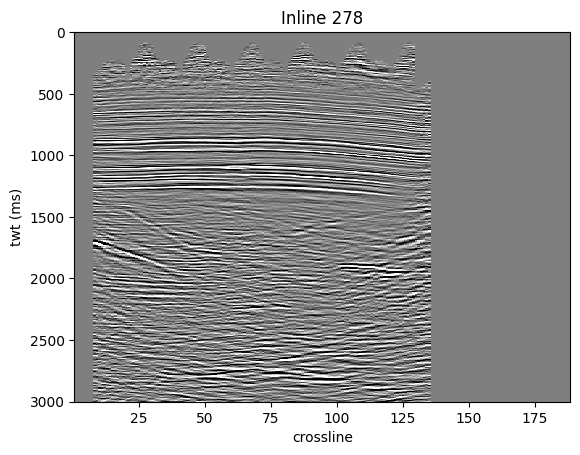

In [11]:
import matplotlib.pyplot as plt


crosslines = mdio.grid.select_dim("crossline").coords
times = mdio.grid.select_dim("sample").coords

std = mdio.stats["std"]

inline_index = mdio.coord_to_index(278, dimensions="inline").item()
il_mask, il_headers, il_data = mdio[inline_index]

vmin, vmax = -2 * std, 2 * std
plt.pcolormesh(crosslines, times, il_data.T, vmin=vmin, vmax=vmax, cmap="gray_r")
plt.gca().invert_yaxis()
plt.title(f"Inline {278}")
plt.xlabel("crossline")
plt.ylabel("twt (ms)");

Let's do the same with a time sample.

We already have crossline labels and standard deviation, so we don't have to fetch it again.

We will display two-way-time at 1,000 ms.

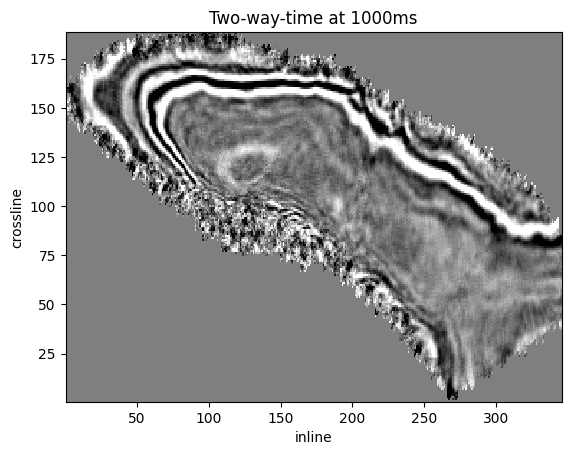

In [12]:
inlines = mdio.grid.select_dim("inline").coords

twt_index = mdio.coord_to_index(1_000, dimensions="sample").item()
z_mask, z_headers, z_data = mdio[:, :, twt_index]

vmin, vmax = -2 * std, 2 * std
plt.pcolormesh(inlines, crosslines, z_data.T, vmin=vmin, vmax=vmax, cmap="gray_r")
plt.title(f"Two-way-time at {1000}ms")
plt.xlabel("inline")
plt.ylabel("crossline");

We can also overlay live mask with the time slice. However, in this example dataset is zero padded.

The live mask will always show True.

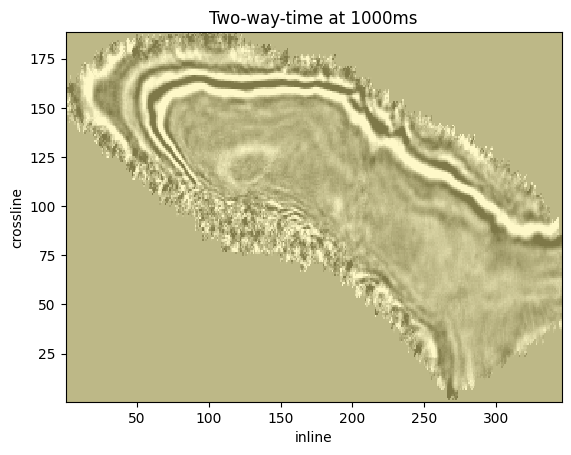

In [13]:
live_mask = mdio.live_mask[:]

plt.pcolormesh(inlines, crosslines, live_mask.T, vmin=0, vmax=1, alpha=0.5)
plt.pcolormesh(inlines, crosslines, z_data.T, vmin=vmin, vmax=vmax, cmap="gray_r", alpha=0.5)
plt.title(f"Two-way-time at {1000}ms")
plt.xlabel("inline")
plt.ylabel("crossline");

## Query Headers

We can query headers for the whole dataset very quickly because they are separated from the seismic wavefield.

Let's get all the headers for X and Y coordinates in this dataset.

As mentioned before, X Coordinates map to `inline` and Y Coordinates map to `crossline` due to non-standard Teapot data.

Note that the header maps will still honor the geometry/grid of the dataset!

In [14]:
mdio._headers[:]["inline"]  # actually cdp_x

array([[788937, 789047, 789157, ..., 809282, 809392, 809502],
       [788935, 789045, 789155, ..., 809279, 809389, 809499],
       [788932, 789042, 789152, ..., 809276, 809386, 809496],
       ...,
       [788044, 788154, 788264, ..., 808389, 808499, 808609],
       [788042, 788152, 788262, ..., 808386, 808496, 808606],
       [788039, 788149, 788259, ..., 808383, 808493, 808603]], dtype=int32)

In [15]:
mdio._headers[:]["crossline"]  # actually cdp_y

array([[938846, 938848, 938851, ..., 939329, 939331, 939334],
       [938956, 938958, 938961, ..., 939439, 939441, 939444],
       [939066, 939068, 939071, ..., 939549, 939551, 939554],
       ...,
       [976455, 976458, 976460, ..., 976938, 976941, 976943],
       [976565, 976568, 976570, ..., 977048, 977051, 977053],
       [976675, 976678, 976680, ..., 977158, 977161, 977163]], dtype=int32)

or both at he same time:

In [16]:
mdio._headers[:][["inline", "crossline"]]  # actually cdp_x, cdp_y

array([[(788937, 938846), (789047, 938848), (789157, 938851), ...,
        (809282, 939329), (809392, 939331), (809502, 939334)],
       [(788935, 938956), (789045, 938958), (789155, 938961), ...,
        (809279, 939439), (809389, 939441), (809499, 939444)],
       [(788932, 939066), (789042, 939068), (789152, 939071), ...,
        (809276, 939549), (809386, 939551), (809496, 939554)],
       ...,
       [(788044, 976455), (788154, 976458), (788264, 976460), ...,
        (808389, 976938), (808499, 976941), (808609, 976943)],
       [(788042, 976565), (788152, 976568), (788262, 976570), ...,
        (808386, 977048), (808496, 977051), (808606, 977053)],
       [(788039, 976675), (788149, 976678), (788259, 976680), ...,
        (808383, 977158), (808493, 977161), (808603, 977163)]],
      dtype={'names': ['inline', 'crossline'], 'formats': ['<i4', '<i4'], 'offsets': [188, 192], 'itemsize': 240})

As we mentioned before, we can also get specific slices of headers while fetching a slice.

Let's fetch a crossline, we are still using some previous parameters.

Since crossline is our second dimension, we can put the index in the second `mdio[...]` axis.

Since MDIO returns the headers as well, we can plot the headers on top of the image.

All headers will be returned, so we can select the X-coordinate with key `inline`.

Full headers can be mapped and plotted as well, but we won't demonstrate that here.

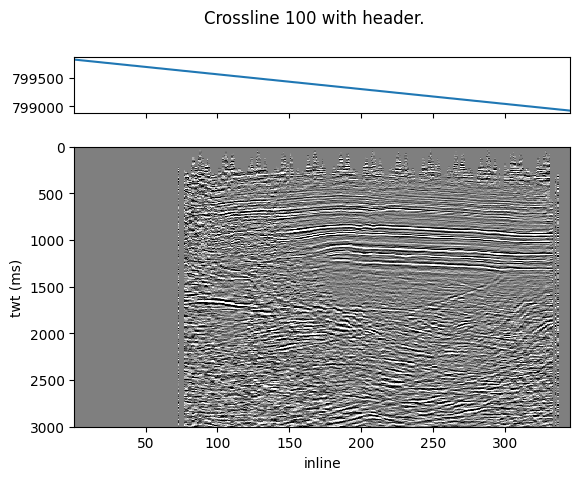

In [17]:
crossline_index = mdio.coord_to_index(100, dimensions="crossline").item()
xl_mask, xl_headers, xl_data = mdio[:, crossline_index]

vmin, vmax = -2 * std, 2 * std

gs_kw = dict(height_ratios=(1, 5))
fig, ax = plt.subplots(2, 1, gridspec_kw=gs_kw, sharex="all")

ax[0].plot(inlines, xl_headers["inline"])

ax[1].pcolormesh(inlines, times, xl_data.T, vmin=vmin, vmax=vmax, cmap="gray_r")
ax[1].invert_yaxis()
ax[1].set_xlabel("inline")
ax[1].set_ylabel("twt (ms)")

plt.suptitle(f"Crossline {100} with header.");

## MDIO to SEG-Y Conversion

Finally, let's demonstrate going back to SEG-Y.

We will use the convenient `mdio_to_segy` function and write it out as a round-trip file.

In [18]:
from mdio import mdio_to_segy

mdio_to_segy(
    mdio_path_or_buffer="filt_mig.mdio",
    output_segy_path="filt_mig_roundtrip.sgy",
)

Merging lines: 100%|██████████| 345/345 [00:00<00:00, 1121.64it/s]


## Validate Round-Trip SEG-Y File

We can validate if the round-trip SEG-Y file is matching the original using [TGSAI/segy][segy-github].

Step by step:
* Open original file
* Open round-trip file
* Compare text headers
* Compare binary headers
* Compare 100 random headers and traces

[segy-github]: https://github.com/TGSAI/segy

In [19]:
import numpy as np
from segy import SegyFile

original_segy = SegyFile(url)
roundtrip_segy = SegyFile("filt_mig_roundtrip.sgy")

# Compare text header
assert original_segy.text_header == roundtrip_segy.text_header

# Compare bin header
assert original_segy.binary_header == roundtrip_segy.binary_header

# Compare 100 random trace headers and traces
rng = np.random.default_rng()
rand_indices = rng.integers(low=0, high=original_segy.num_traces, size=100)
for idx in rand_indices:
    np.testing.assert_equal(original_segy.trace[idx], roundtrip_segy.trace[idx])